# Homework 2
*This notebook includes both coding and written questions. Please hand in this notebook file with all the outputs and your answers to the written questions.*

This assignment covers Canny edge detector and Hough transform.

In [1]:
# Setup
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from time import time
from skimage import io

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

## Part 1: Canny Edge Detector (85 points)
In this part, you are going to implement a Canny edge detector. The Canny edge detection algorithm can be broken down in to five steps:
1. Smoothing
2. Finding gradients
3. Non-maximum suppression
4. Double thresholding
5. Edge tracking by hysterisis

### 1.1 Smoothing (10 points)
#### Implementation (5 points)
We first smooth the input image by convolving it with a Gaussian kernel. The equation for a Gaussian kernel of size $(2k+1)\times(2k+1)$ is given by:

$$h_{ij}=\frac{1}{2\pi\sigma^2}\exp{\Bigl(-\frac{(i-k)^2+(j-k)^2}{2\sigma^2}\Bigr)}, 0\leq i,j < 2k+1$$

Implement **`gaussian_kernel`** in `edge.py` and run the code below.

In [2]:
from edge import conv, gaussian_kernel

# Define 3x3 Gaussian kernel with std = 1
kernel = gaussian_kernel(3, 1)
kernel_test = np.array(
    [[ 0.05854983, 0.09653235, 0.05854983],
     [ 0.09653235, 0.15915494, 0.09653235],
     [ 0.05854983, 0.09653235, 0.05854983]]
)

# Test Gaussian kernel
if not np.allclose(kernel, kernel_test):
    print('Incorrect values! Please check your implementation.')

Implement **`conv`** in `edge.py` and run the code below.

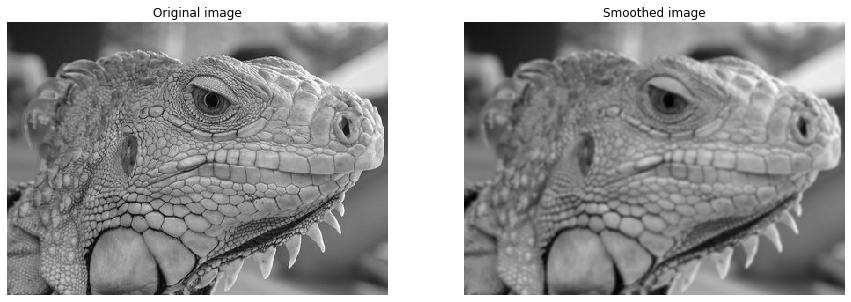

In [3]:
# Test with different kernel_size and sigma
kernel_size = 5
sigma = 1.4

# Load image
img = io.imread('iguana.png', as_gray=True)

# Define 5x5 Gaussian kernel with std = sigma
kernel = gaussian_kernel(kernel_size, sigma)

# Convolve image with kernel to achieve smoothed effect
smoothed = conv(img, kernel)

plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(smoothed)
plt.title('Smoothed image')
plt.axis('off')

plt.show()

#### Question (5 points)
What is the effect of changing kernel_size and sigma?

**Your Answer:** Write your solution in this markdown cell.

### 1.2 Finding gradients (15 points)
The gradient of a 2D scalar function $I:\mathbb{R}^2\rightarrow{\mathbb{R}}$ in Cartesian coordinate is defined by:

$$\nabla{I(x,y)}=\bigl[\frac{\partial{I}}{\partial{x}},\frac{\partial{I}}{\partial{y}}\bigr],$$

where

$$
\frac{\partial{I(x,y)}}{\partial{x}}=\lim_{\Delta{x}\to{0}}\frac{I(x+\Delta{x},y)-I(x,y)}{\Delta{x}} \\
\frac{\partial{I(x,y)}}{\partial{y}}=\lim_{\Delta{y}\to{0}}\frac{I(x,y+\Delta{y})-I(x,y)}{\Delta{y}}.
$$

In case of images, we can approximate the partial derivatives by taking differences at one pixel intervals:

$$
\frac{\partial{I(x,y)}}{\partial{x}}\approx{\frac{I(x+1,y)-I(x-1,y)}{2}} \\
\frac{\partial{I(x,y)}}{\partial{y}}\approx{\frac{I(x,y+1)-I(x,y-1)}{2}}
$$

Note that the partial derivatives can be computed by convolving the image $I$ with some appropriate kernels $D_x$ and $D_y$:

$$
\frac{\partial{I}}{\partial{x}}\approx{I*D_x}=G_x \\
\frac{\partial{I}}{\partial{y}}\approx{I*D_y}=G_y
$$

#### Implementation (5 points)
Find the kernels $D_x$ and $D_y$ and implement **`partial_x`** and **`partial_y`** using `conv` defined in `edge.py`.

*-Hint: Remeber that convolution flips the kernel.*

In [4]:
from edge import partial_x, partial_y

# Test input
I = np.array(
    [[0, 0, 0],
     [0, 1, 0],
     [0, 0, 0]]
)

# Expected outputs
I_x_test = np.array(
    [[ 0, 0, 0],
     [ 0.5, 0, -0.5],
     [ 0, 0, 0]]
)

I_y_test = np.array(
    [[ 0, 0.5, 0],
     [ 0, 0, 0],
     [ 0, -0.5, 0]]
)

# Compute partial derivatives
I_x = partial_x(I)
I_y = partial_y(I)

# Test correctness of partial_x and partial_y
if not np.all(I_x == I_x_test):
    print('partial_x incorrect')
    
if not np.all(I_y == I_y_test):
    print('partial_y incorrect')

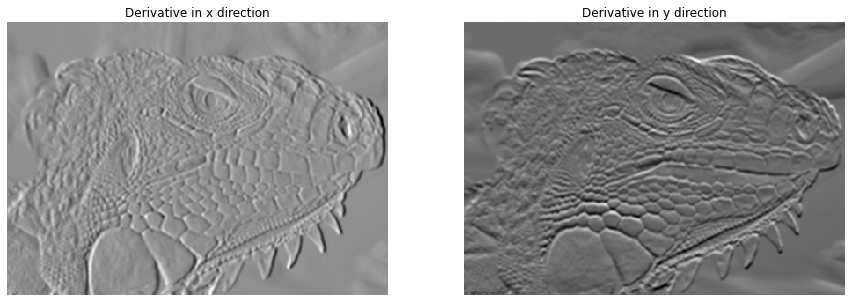

In [5]:
# Compute partial derivatives of smoothed image
Gx = partial_x(smoothed)
Gy = partial_y(smoothed)

plt.subplot(1,2,1)
plt.imshow(Gx)
plt.title('Derivative in x direction')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(Gy)
plt.title('Derivative in y direction')
plt.axis('off')

plt.show()

#### Question (5 points)
What is the reason for performing smoothing prior to computing the gradients?

**Your Answer:** Write your solution in this markdown cell.

#### Implementation (5 points)
Now, we can compute the magnitude and direction of gradient with the two partial derivatives:

$$
G = \sqrt{G_{x}^{2}+G_{y}^{2}} \\
\Theta = arctan\bigl(\frac{G_{y}}{G_{x}}\bigr)
$$

Implement **`gradient`** in `edge.py` which takes in an image and outputs $G$ and $\Theta$.

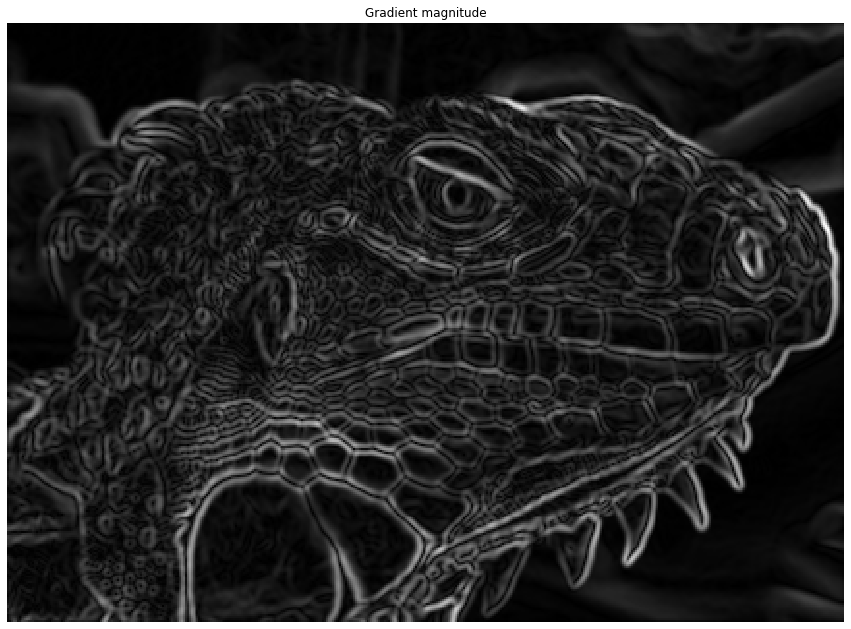

In [6]:
from edge import gradient

G, theta = gradient(smoothed)

if not np.all(G >= 0):
    print('Magnitude of gradients should be non-negative.')
    
if not np.all((theta >= 0) * (theta < 360)):
    print('Direction of gradients should be in range 0 <= theta < 360')

plt.imshow(G)
plt.title('Gradient magnitude')
plt.axis('off')
plt.show()

### 1.3 Non-maximum suppression (15 points)
You should be able to see that the edges extracted from the gradient of the smoothed image are quite thick and blurry. The purpose of this step is to convert the "blurred" edges into "sharp" edges. Basically, this is done by preserving all local maxima in the gradient image and discarding everything else. The algorithm is for each pixel (x,y) in the gradient image:
1. Round the gradient direction $\Theta[y,x]$ to the nearest 45 degrees, corresponding to the use of an 8-connected neighbourhood.

2. Compare the edge strength of the current pixel with the edge strength of the pixel in the positive and negative gradient directions. For example, if the gradient direction is south (theta=90), compare with the pixels to the north and south.

3. If the edge strength of the current pixel is the largest; preserve the value of the edge strength. If not, suppress (i.e. remove) the value.

Implement **`non_maximum_suppression`** in `edge.py`.

We provide the correct output and the difference between it and your result for debugging purposes.  If you see white spots in the Difference image, you should check your implementation.

In [7]:
theta.shape, G.shape

((310, 433), (310, 433))

In [8]:
from edge import non_maximum_suppression

# Test input
g = np.array(
    [[0.4, 0.5, 0.6],
     [0.3, 0.5, 0.7],
     [0.4, 0.5, 0.6]]
)

# Print out non-maximum suppressed output
# varying theta
for angle in range(0, 180, 45):
    #print('Thetas:', angle)
    t = np.ones((3, 3)) * angle # Initialize theta
    # print(non_maximum_suppression(g, t))
    non_maximum_suppression(g, t)


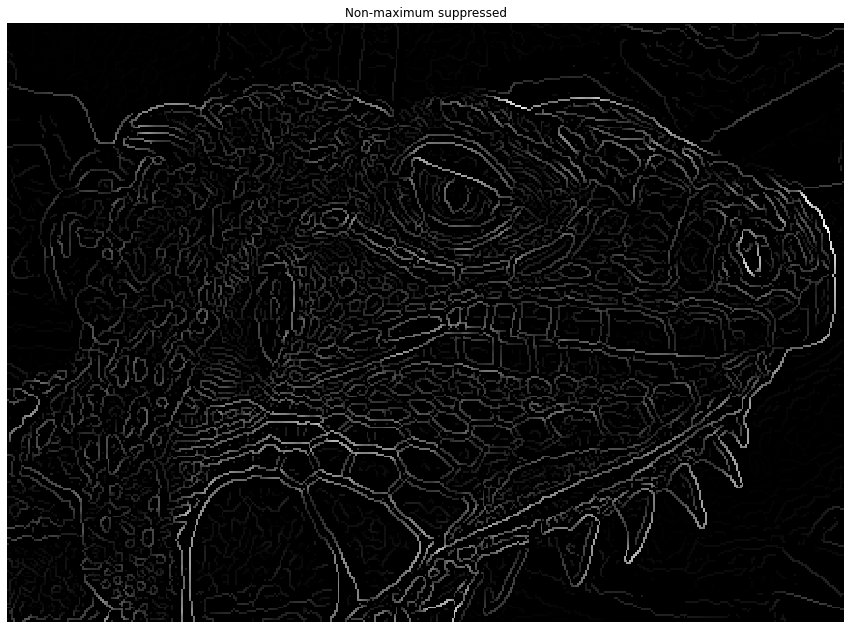

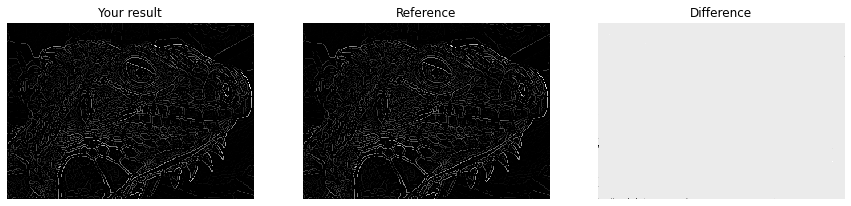

0.0034553102222550135

In [9]:
nms = non_maximum_suppression(G, theta)
plt.imshow(nms)
plt.title('Non-maximum suppressed')
plt.axis('off')
plt.show()

plt.subplot(1, 3, 1)
plt.imshow(nms)
plt.axis('off')
plt.title('Your result')

plt.subplot(1, 3, 2)
reference = np.load('references/iguana_non_max_suppressed.npy')
plt.imshow(reference)
plt.axis('off')
plt.title('Reference')

plt.subplot(1, 3, 3)
plt.imshow(nms - reference)
plt.title('Difference')
plt.axis('off')
plt.show()

np.amax(nms-reference)

### 1.4 Double Thresholding (20 points)

The edge-pixels remaining after the non-maximum suppression step are (still) marked with their strength pixel-by-pixel. Many of these will probably be true edges in the image, but some may be caused by noise or color variations, for instance, due to rough surfaces. The simplest way to discern between these would be to use a threshold, so that only edges stronger that a certain value would be preserved. The Canny edge detection algorithm uses double thresholding. Edge pixels stronger than the high threshold are marked as strong; edge pixels weaker than the low threshold are suppressed and edge pixels between the two thresholds are marked as weak.

Implement **`double_thresholding`** in `edge.py`

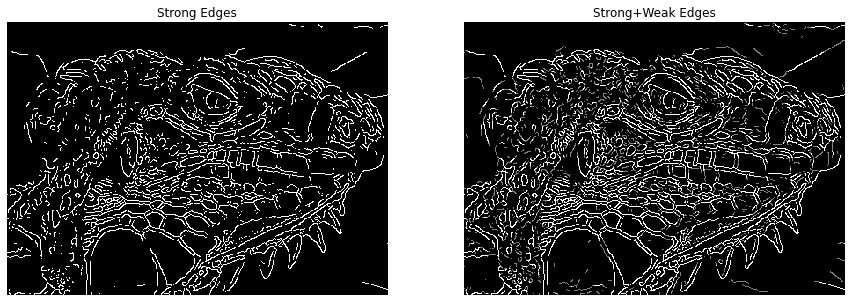

In [10]:
from edge import double_thresholding

low_threshold = 0.02
high_threshold = 0.03

strong_edges, weak_edges = double_thresholding(nms, high_threshold, low_threshold)
assert(np.sum(strong_edges & weak_edges) == 0)

edges=strong_edges * 1.0 + weak_edges * 0.5

plt.subplot(1,2,1)
plt.imshow(strong_edges)
plt.title('Strong Edges')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(edges)
plt.title('Strong+Weak Edges')
plt.axis('off')

plt.show()

### 1.5 Edge tracking (15 points)

Strong edges are interpreted as “certain edges”, and can immediately be included in the final edge image. Consider its neighbors iteratively then declare it an 'edge pixel' if it is connected to a 'strong edge pixel' directly or via pixels between Low and High. The logic is of course that noise and other small variations are unlikely to result in a strong edge (with proper adjustment of the threshold levels). Thus strong edges will (almost) only be due to true edges in the original image. The weak edges can either be due to true edges or noise/color variations. The latter type will probably be distributed independently of edges on the entire image, and thus only a small amount will be located adjacent to strong edges. Weak edges due to true edges are much more likely to be connected directly to strong edges.

Implement **`link_edges`** in `edge.py`.

We provide the correct output and the difference between it and your result for debugging purposes.  If you see white spots in the Difference image, you should check your implementation.

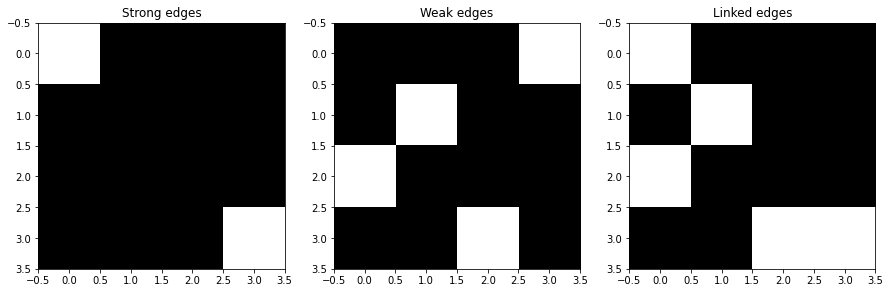

In [11]:
from edge import get_neighbors, link_edges

test_strong = np.array(
    [[1, 0, 0, 0],
     [0, 0, 0, 0],
     [0, 0, 0, 0],
     [0, 0, 0, 1]],
    dtype=np.bool
)

test_weak = np.array(
    [[0, 0, 0, 1],
     [0, 1, 0, 0],
     [1, 0, 0, 0],
     [0, 0, 1, 0]],
    dtype=np.bool
)

test_linked = link_edges(test_strong, test_weak)

plt.subplot(1, 3, 1)
plt.imshow(test_strong)
plt.title('Strong edges')

plt.subplot(1, 3, 2)
plt.imshow(test_weak)
plt.title('Weak edges')

plt.subplot(1, 3, 3)
plt.imshow(test_linked)
plt.title('Linked edges')
plt.show()

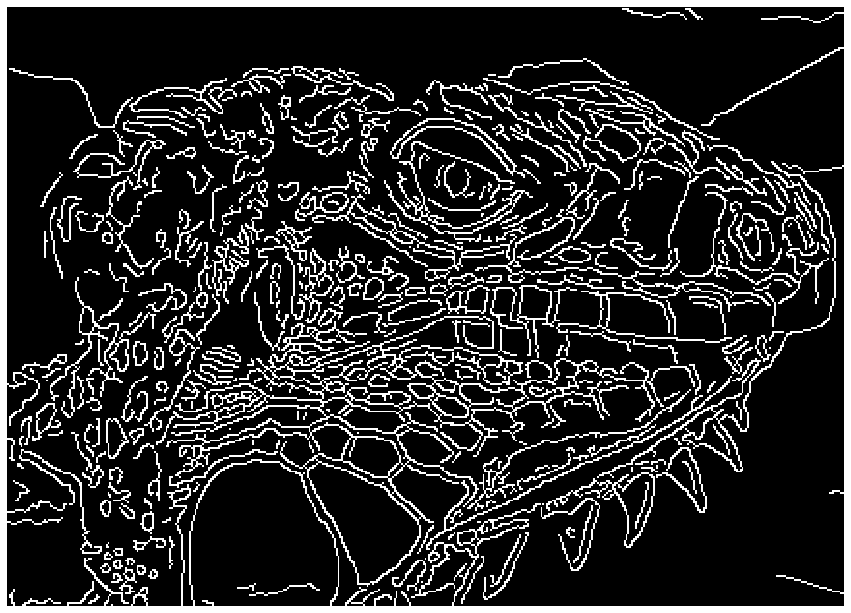

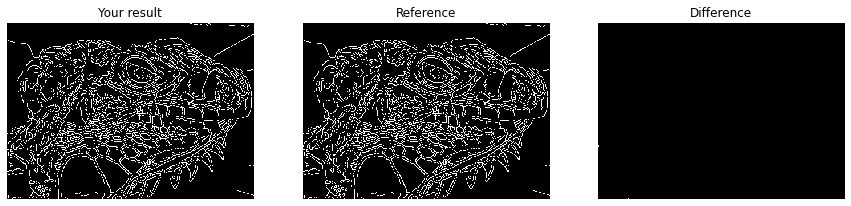

In [12]:
edges = link_edges(strong_edges, weak_edges)

plt.imshow(edges)
plt.axis('off')
plt.show()

plt.subplot(1, 3, 1)
plt.imshow(edges)
plt.axis('off')
plt.title('Your result')

plt.subplot(1, 3, 2)
reference = np.load('references/iguana_edge_tracking.npy')
plt.imshow(reference)
plt.axis('off')
plt.title('Reference')

plt.subplot(1, 3, 3)
plt.imshow(edges ^ reference)
plt.title('Difference')
plt.axis('off')
plt.show()

### 1.6 Canny edge detector
Implement **`canny`** in `edge.py` using the functions you have implemented so far. Test edge detector with different parameters.

Here is an example of the output:

![iguana_edges.png](iguana_edges.png)

We provide the correct output and the difference between it and your result for debugging purposes.  If you see white spots in the Difference image, you should check your implementation.

(310, 433)


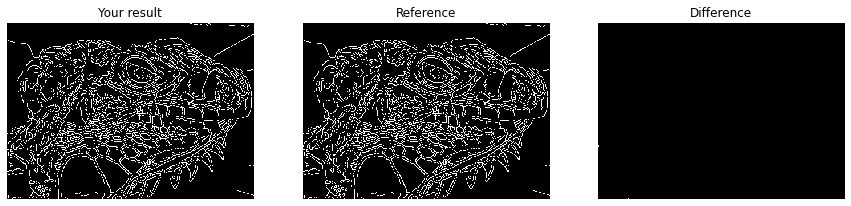

In [13]:
from edge import canny

# Load image
img = io.imread('iguana.png', as_gray=True)

# Run Canny edge detector
edges = canny(img, kernel_size=5, sigma=1.4, high=0.03, low=0.02)
print (edges.shape)

plt.subplot(1, 3, 1)
plt.imshow(edges)
plt.axis('off')
plt.title('Your result')

plt.subplot(1, 3, 2)
reference = np.load('references/iguana_canny.npy')
plt.imshow(reference)
plt.axis('off')
plt.title('Reference')

plt.subplot(1, 3, 3)
plt.imshow(edges ^ reference)
plt.title('Difference')
plt.axis('off')
plt.show()

### 1.7 Question (10 points)

![1.7a.png](1.7a.png)

**(a)** Suppose that the Canny edge detector successfully detects an edge in an image. The edge (see the figure above) is then rotated by θ, where the relationship between a point on the original edge $(x, y)$ and a point on the rotated edge $(x', y')$ is defined as

$$
x'=x\cos{\theta}\\
y'=x\sin{\theta}
$$

Will the rotated edge be detected using the same Canny edge detector? Provide either a mathematical proof or a counter example.

*-Hint 1: The detection of an edge by the Canny edge detector depends only on the magnitude of its derivative. The derivative at point (x, y) is determined by its components along the x and y directions. Think about how these magnitudes have changed because of the rotation.* <br>
*-Hint 2: You can assume that (x,y) lies on the x-axis, i.e., y = 0. * <br>
*-Hint 3: You can also assume that G_x(x, y) = 0. In other words, the gradient which is perpendicular to the direction of the unrotated edge at (x, y) only has a vertical component and thus only consists of G_y(x, y).*

**Your Answer:** Write your solution in this markdown cell.

**(b)** After running the Canny edge detector on an image, you notice that long edges are broken into short segments separated by gaps. In addition, some spurious edges appear. For each of the two thresholds (low and high) used in hysteresis thresholding, explain how you would adjust the threshold (up or down) to address both problems. Assume that a setting exists for the two thresholds that produces the desired result. Briefly explain your answer.

**Your Answer:** Write your solution in this markdown cell.

### Extra Credit: Optimizing Edge Detector
One way of evaluating an edge detector is to compare detected edges with manually specified ground truth edges. Here, we use precision, recall and F1 score as evaluation metrics. We provide you 40 images of objects with ground truth edge annotations. Run the code below to compute precision, recall and F1 score over the entire set of images. Then, tweak the parameters of the Canny edge detector to get as high F1 score as possible. You should be able to achieve F1 score higher than 0.31 by carefully setting the parameters.

In [14]:
from os import listdir
from itertools import product
from tqdm import tqdm

# Define parameters to test
# sigmas = [1, 1.4, 1,5, 1,75]
# highs = [10, 15, 20, 25]
# lows = [10 , 15, 20, 25]

# Final parameters choose
sigmas = [1]
highs = [10]
lows = [10]

for sigma, high, low in product(sigmas, highs, lows):

    print("sigma={}, high={}, low={}".format(sigma, high, low))
    n_detected = 0.0
    n_gt = 0.0
    n_correct = 0.0
    listDirImage = listdir('images/objects')
    for img_file in tqdm(listDirImage, total=len(listDirImage)):
        img = io.imread('images/objects/'+img_file, as_gray=True)
        gt = io.imread('images/gt/'+img_file+'.gtf.pgm', as_gray=True)

        mask = (gt != 5) # 'don't' care region
        gt = (gt == 0) # binary image of GT edges

        edges = canny(img, kernel_size=5, sigma=sigma, high=high, low=low)
        edges = edges * mask

        n_detected += np.sum(edges)
        n_gt += np.sum(gt)
        n_correct += np.sum(edges * gt)

    p_total = n_correct / n_detected
    r_total = n_correct / n_gt
    f1 = 2 * (p_total * r_total) / (p_total + r_total)
    print('Total precision={:.4f}, Total recall={:.4f}'.format(p_total, r_total))
    print('F1 score={:.4f}'.format(f1))

sigma=1, high=10, low=10


100%|█████████████████████████| 40/40 [03:54<00:00,  5.87s/it]

Total precision=0.2757, Total recall=0.3987
F1 score=0.3260


## Part2: Lane Detection (15 points)

In this section we will implement a simple lane detection application using Canny edge detector and Hough transform.
Here are some example images of how your final lane detector will look like.
<img src="lane1.png" width="400">
<img src="lane2.png" width="400">

The algorithm can broken down into the following steps:
1. Detect edges using the Canny edge detector.
2. Extract the edges in the region of interest (a triangle covering the bottom corners and the center of the image).
3. Run Hough transform to detect lanes.



### 2.1 Edge detection
Lanes on the roads are usually thin and long lines with bright colors. Our edge detection algorithm by itself should be able to find the lanes pretty well. Run the code cell below to load the example image and detect edges from the image.

In [ ]:
from edge import canny

# Load image
img = io.imread('road.jpg', as_gray=True)

# Run Canny edge detector
edges = canny(img, kernel_size=5, sigma=1.4, high=0.03, low=0.02)

plt.subplot(211)
plt.imshow(img)
plt.axis('off')
plt.title('Input Image')

plt.subplot(212)
plt.imshow(edges)
plt.axis('off')
plt.title('Edges')
plt.show()

### 2.2 Extracting region of interest (ROI)
We can see that the Canny edge detector could find the edges of the lanes. However, we can also see that there are edges of other objects that we are not interested in. Given the position and orientation of the camera, we know that the lanes will be located in the lower half of the image. The code below defines a binary mask for the ROI and extract the edges within the region.

In [ ]:
H, W = img.shape

# Generate mask for ROI (Region of Interest)
mask = np.zeros((H, W))
for i in range(H):
    for j in range(W):
        if i > (H / W) * j and i > -(H / W) * j + H:
            mask[i, j] = 1

# Extract edges in ROI
roi = edges * mask

plt.subplot(1,2,1)
plt.imshow(mask)
plt.title('Mask')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(roi)
plt.title('Edges in ROI')
plt.axis('off')
plt.show()

### 2.3 Fitting lines using Hough transform (15 points)
The output from the edge detector is still a collection of connected points. However, it would be more natural to represent a lane as a line parameterized as $y = ax + b$, with a slope $a$ and y-intercept $b$. We will use Hough transform to find parameterized lines that represent the detected edges.

In general, a straight line $y = ax + b$ can be represented as a point $(a, b)$ in the parameter space. This is the parameterization we often use when introducing the Hough transform.  However, this cannot represent vertical lines as the slope parameter will be unbounded. Alternatively, we parameterize a line using $\theta\in{[-\pi, \pi]}$ and $\rho\in{\mathbb{R}}$ as follows:

$$
\rho = x\cdot{cos\theta} + y\cdot{sin\theta}
$$

Using this parameterization, we can map every point in $xy$-space to a sine-like line in $\theta\rho$-space (or Hough space). We then accumulate the parameterized points in the Hough space and choose points (in Hough space) with highest accumulated values. A point in Hough space then can be transformed back into a line in $xy$-space.

*See [notes](http://web.ipac.caltech.edu/staff/fmasci/home/astro_refs/HoughTrans_lines_09.pdf) on Hough transform.*

Implement **`hough_transform`** in `edge.py`.

In [ ]:
from edge import hough_transform

# Perform Hough transform on the ROI
acc, rhos, thetas = hough_transform(roi)

# Coordinates for right lane
xs_right = []
ys_right = []

# Coordinates for left lane
xs_left = []
ys_left = []

for i in range(20):
    idx = np.argmax(acc)
    r_idx = idx // acc.shape[1]
    t_idx = idx % acc.shape[1]
    acc[r_idx, t_idx] = 0 # Zero out the max value in accumulator

    rho = rhos[r_idx]
    theta = thetas[t_idx]
    
    # Transform a point in Hough space to a line in xy-space.
    a = - (np.cos(theta)/np.sin(theta)) # slope of the line
    b = (rho/np.sin(theta)) # y-intersect of the line

    # Break if both right and left lanes are detected
    if xs_right and xs_left:
        break
    
    if a < 0: # Left lane
        if xs_left:
            continue
        xs = xs_left
        ys = ys_left
    else: # Right Lane
        if xs_right:
            continue
        xs = xs_right
        ys = ys_right

    for x in range(img.shape[1]):
        y = a * x + b
        if y > img.shape[0] * 0.6 and y < img.shape[0]:
            xs.append(x)
            ys.append(int(round(y)))

plt.imshow(img)
plt.plot(xs_left, ys_left, linewidth=5.0)
plt.plot(xs_right, ys_right, linewidth=5.0)
plt.axis('off')
plt.show()